In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# base libraries
import copy
import gc
import multiprocessing
from multiprocessing import Pool
import os
from pathlib import Path
import sys
import time

# installed libraries
import cv2
import imageio
import numpy as np
import numpy.matlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import scipy
import scipy.signal
import sklearn as sk
import sklearn.decomposition
import skimage.draw
import torchinterp1d
from tqdm import tqdm
import yaml

In [3]:
dir_githubRepos = Path(r'D:\RH_local\github').resolve()

import sys
# sys.path.append('/n/groups/datta/akshay/bmi')
sys.path.append(str(dir_githubRepos))

# from Cascade import cascade2p.cascade2p
from Cascade.cascade2p import checks
checks.check_packages()
from Cascade.cascade2p import cascade # local folder
from Cascade.cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

# my libraries
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

	YAML reader installed (version 0.17.2).
	Keras installed (version 2.5.0).
	Tensorflow installed (version 2.5.0).


In [4]:
## == IMPORT DATA ==
dir_s2p = Path(r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210416\exp\suite2p\plane0').resolve()

F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

Calculated dFoF. Total elapsed time: 8.73 seconds
ThreadPool elapsed time : 1.09 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 1.84 seconds


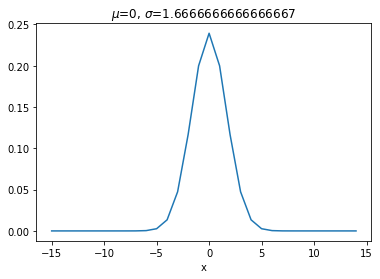

In [5]:
# Cascade

channelOffset_correction = 500
percentile_baseline = 10
dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F + channelOffset_correction,
                                                                 Fneu=Fneu + channelOffset_correction,
                                                                 neuropil_fraction=0.7,
                                                                 percentile_baseline=percentile_baseline,
                                                                 multicore_pref=True,
                                                                 verbose=True)
dFoF_smooth = timeSeries.convolve_along_axis(dFoF,
                                             kernel=math_functions.gaussian(np.arange(-(Fs)//2, (Fs)//2), 0, sig=50/Fs, plot_pref=True)[0],
                                             axis=1,mode='same',
                                             multicore_pref=True,
                                             verbose=True).astype(np.float32)

<IPython.core.display.Javascript object>


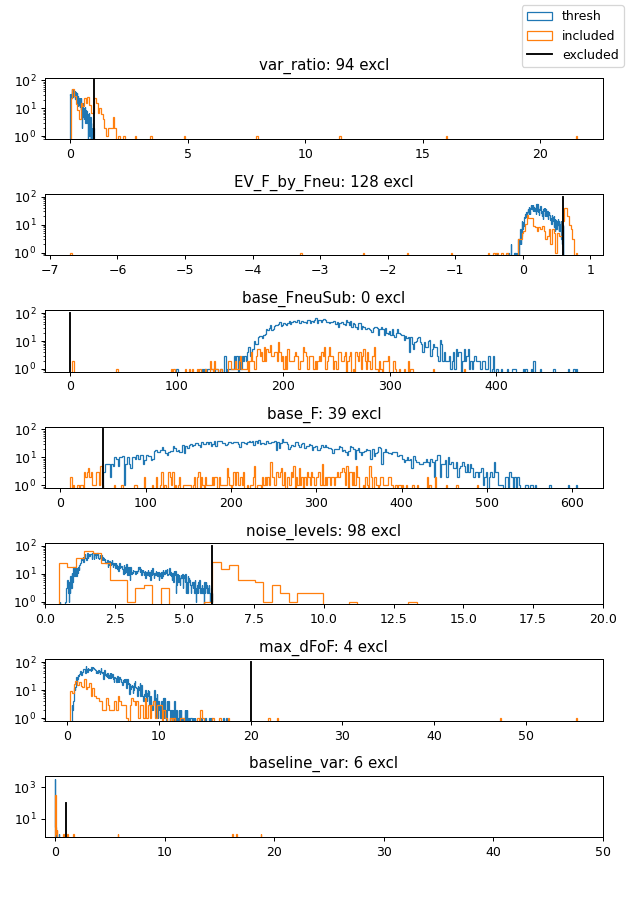

<IPython.core.display.Javascript object>


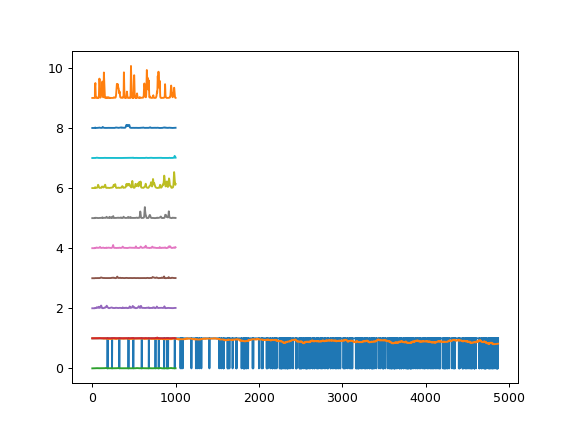

ROIs excluded: 340 / 4869
ROIs included: 4529 / 4869


In [6]:
%matplotlib notebook

thresh = {
            'var_ratio': 1,
            'EV_F_by_Fneu': 0.6,
            'base_FneuSub': 0,
            'base_F': 50,
            'noise_levels': 6,
            'max_dFoF': 20,
            'baseline_var': 1,
        }

# thresh = {
#             'var_ratio': np.inf,
#             'EV_F_by_Fneu': np.inf,
#             'base_FneuSub': -np.inf,
#             'base_F': -np.inf,
#             'noise_levels': 6,
#             'max_dFoF': np.inf,
#             'baseline_var': np.inf,
#         }
    
tqm, iscell_tqm = ca2p_preprocessing.trace_quality_metrics(
    F,
    Fneu,
    dFoF,
    dF,
    F_neuSub,
    F_baseline,
    percentile_baseline=percentile_baseline,
    Fs=Fs,
    plot_pref=True,
    thresh=thresh,
)
idxROI_tqm_toInclude = np.where(iscell_tqm)[0]
idxROI_tqm_toExclude = np.where(~iscell_tqm)[0]

In [9]:
dir_cascade = dir_githubRepos / 'Cascade'

In [31]:
def show_available_models(dir_cascade):
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    cascade.download_model('update_models', model_folder=dir_cascade, verbose = 1)

    yaml_file = open(dir_cascade / 'Pretrained_models/available_models.yaml')
    # yaml_file = open('Pretrained_models/available_models.yaml')
    X = yaml.load(yaml_file, Loader=yaml.Loader)
    list_of_models = list(X.keys())
    print('\n List of available models: \n')
    for model in list_of_models:
        print(model)

def download_model(model_name='Global_EXC_30Hz_smoothing50ms_causalkernel', dir_cascade='/', verbose=True):
    cascade.download_model( model_name, model_folder=dir_cascade, verbose = 1)

def predict(traces, dir_cascade='/', num_batches=1, empty_list_for_inplace_dataRecovery=[]):
    spike_probs = empty_list_for_inplace_dataRecovery
    with tqdm(total=num_batches) as pbar:
        for batch in indexing.make_batches(traces, num_batches=num_batches):
            spike_prob = cascade.predict(model_name=model_name,
                                                     traces=batch, 
                                                     model_folder=dir_cascade, 
                                                     padding=0)
            spike_probs.append(spike_prob)
            pbar.update(1)

    spks_cas = np.concatenate(spike_probs, axis=0).astype(np.float32)
    return spks_cas

In [35]:
# show_available_models(dir_cascade)

In [34]:
model_name = 'Global_EXC_30Hz_smoothing50ms_causalkernel'

download_model( model_name, dir_cascade=dir_cascade, verbose=True)

Pretrained model was saved in folder "D:\RH_local\github\Cascade\Global_EXC_30Hz_smoothing50ms_causalkernel"


In [ ]:
test = []
test2 = predict(
    traces=dFoF_smooth[:50],
    dir_cascade=dir_cascade,
    num_batches=10,
    empty_list_for_inplace_dataRecovery=test
)

np.save(dir_s2p / 'spks_cas.npy', np.single(spike_prob_array))

<IPython.core.display.Javascript object>


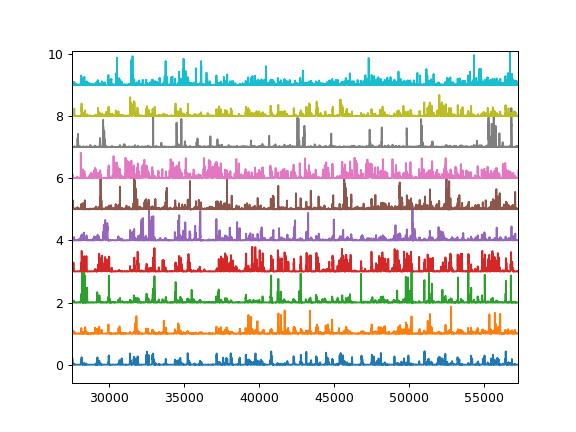

In [17]:
plt.figure()
plt.plot(spike_prob[:10,:].T+np.arange(0,10))
plt.show()

In [ ]:
pc_components , pc_scores , pc_evr , _ = decomposition.simple_pca(
    spks_cas.T,
    n_components=None,
    mean_sub=True,
    zscore=False,
#     plot_pref=False,
#     n_PCs_toPlot=2,
)

<IPython.core.display.Javascript object>


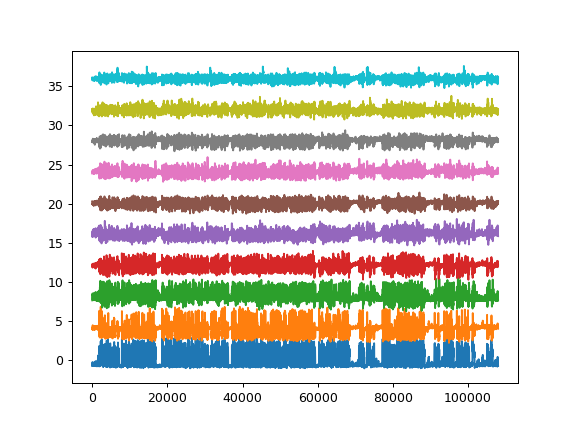

In [30]:
plt.figure()
plt.plot(pc_scores[:,:10] + np.arange(0,10)*4);